# Домашнее задание 8

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 21 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_8

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
#Проекция на симплекс
import numpy as np
def true_simplex_proj(y : np.array):
    #предварительная работа
    D = len(y)
    ySorted = np.flip(np.sort(y, kind='heapsort'))
    sums = np.cumsum(ySorted)
    someArray = [ySorted[j] + (1/(j+1))*(1 - sums[j]) for j in range(D)]

    #поиск максимального индекса, при котором выражение положительно
    r = float('-inf')
    for i in range(D):
        if someArray[i] > 0: r = i
  
    lam = (1-sums[r])/(r+1)

    #делаем проекцию
    x = np.copy([max(y[i] + lam, 0) for i in range(D)])
    return x

In [3]:
from scipy.stats import ortho_group
from scipy.stats import uniform
def get_matrix_2(d,mu,L,seed=5):
    vec=np.array(uniform.rvs(loc=1.1*mu,scale=L*0.9,size=d-2,random_state=seed))
    vec=np.append(vec,mu)
    vec=np.append(vec,L)
    O=ortho_group.rvs(dim=d,random_state=seed)
    D=np.diag(vec)
    temp=np.matmul(np.transpose(O),D)
    result = np.matmul(temp,O)
    return result

## Задача 1

Рассмотрим билинейную седловую задачу:
\begin{equation}
\min_{x \in [-10; 10]^d} \max_{y \in [-10; 10]^d} f(x,y) = (x-b_x)^T A (y - b_y) + \frac{\lambda}{2}\| x - b_x\|^2 - \frac{\lambda}{2}\| y - b_y\|^2,
\end{equation}
где в качестве матрицы $A$ - случайно сгенерированная матрица с $L =1000$, $\mu = 0.01$, $d = 100$, $b_x$ и $b_y$ - случайные векторы c компонентами из отрезка $[-10; 10]$, $\lambda = 1$.

__(а)__ Какое решение у данной задачи? Является ли данная задача сильно выпуклой по $x$ и сильно вогнутой по $y$? Если да, то чему равна константа сильной выпуклости? Является ли оператор, соотвествующего это задаче вариационного неравенства, сильно монотонным? Липшицевым? Чему равны $L$ и $\mu$ для данного оператора? 

### Решение

на семинаре показали что это можно свести к вариационному неравенству

$\left<F(z^*) z-z^* \right> >=0 $

с оператором $F(z)$:

$F(z)=(A(y-b_y)+\lambda(x-b_x);-(x-b_x)A+\lambda(y-b_y))$

Забудем на секунду, что задача решается на кубе. Тогда в точке ее решения градиенты будут равны нулю

$A(y-b_y)+\lambda(x-b_x) = 0;\;\;\; -(x-b_x)^TA+\lambda(y-b_y)=0$

Отсюда следует, что решение системы это $(x,y)=(b_x,b_y)$

Эта точка лежит внутри куба, значит что теперь все хорошо.

### Выпуклость и вогнутость

Действуем по определению - фиксируем игрик, рассматриваем $f(x,y)=g_y(x)$ только как функцию икса

Тогда если рассмотреть ее Гессиан, то получим $\lambda$. Аналогично, если смотреть на гессиан $h_x(y)$, то получим $-\lambda$. Отсюда получим что $f(x,y)$ является сильно выпуклой по иксу и сильно вогнутой по игрику. При этом $\lambda$ - константа выпуклости для обоих перменных

### Сильная монотонность, липшицевость, константы

По определнию нужно, чтобы

$\left<F(z_1)-F(z_2),z_1-z_2 \right> \geq \mu ||z_1-z_2||^2$

Подставим, раскроем, получим :

$\lambda||x_1-x_2||^2+\lambda||y_1-y_2||^2=\lambda||z_1-z_2||^2$

Отсюда получим, что оператор сильно монотонный с константой лямбда

$||F(z_1)-F(z_2)||^2 \leq L_A^2(||x_1-x_2||^2+||y_1-y_2||^2)+\lambda^2(||x_1-x_2||^2)+||y_1-y_2||^2)$

$L$ можно оценить как $\sqrt{L_A^2+\lambda^2}$

__(б)__ Решите данную задачу с помощью метода градиентного спуска(подъема) с проекцией и с помощью метода Экстраградиента с проекцией(смотри Секцию 3.3 [статью](https://arxiv.org/pdf/1802.10551.pdf)). Для начала попробуйте теоретические шаги для данных методов. Далее подберите шаг для наилучшей сходимости. Постройте график сходимости (относительное расстояние до решения по аргументу от числа подсчетов градиентов). На графике должно быть 4 линии, по две на каждый из методов. Сделайте вывод.

Генерируем матрицу и векторы :

In [4]:
DIMENSIONS=100
L=1000
mu=0.01
lambda_coef=1
seed=5
A=get_matrix_2(DIMENSIONS,mu,L,5)
bx=np.array(uniform.rvs(loc=-10,scale=20,size=DIMENSIONS,random_state=seed))
by=np.array(uniform.rvs(loc=-10,scale=20,size=DIMENSIONS,random_state=seed+1))

## Пишем экстраградиент

In [5]:
def default_proj(z):
    return z
def segment_proj(z):
    for i in range(len(z)):
        if z[i]>=10:
            z[i]=10
        if z[i]<=-10:
            z[i]=-10
    return z

def ExtraGradient(F,z_start,step,iterations,proj,true_solution):
    z=z_start
    numbers=[]
    R0=np.linalg.norm(z_start-true_solution,2)
    for i in range(iterations):
        z_between=proj(z-step*F(z))
        z_new=proj(z-step*F(z_between))
        z=z_new
        numbers.append(np.linalg.norm(z-true_solution,2)/R0) #Относительное расстояние   
    return z,numbers

In [6]:
L=np.linalg.norm(A,2)
L

999.9999999999998

In [7]:
def x_grad(A, bx,by,lambd,x,y): 
    return np.dot(A,y-by)+lambd*(x-bx)
def y_grad(A, bx,by,lambd,x,y):
    return np.dot(A,x-bx)+lambd*(by-y)

In [8]:
def F_prep(x_grad,y_grad,z):
    x=z[:int(len(z)/2)]
    y=z[int(len(z)/2):]
    first=x_grad(A,bx,by,1,x,y)
    second=-y_grad(A,bx,by,1,x,y)
    return np.hstack([first,second])

In [9]:
F = lambda z: F_prep(x_grad,y_grad,z)

# Тесты

## Экстраградиент

In [10]:
theor_step=1/3/L
steps=[theor_step/10,theor_step/5,theor_step,theor_step*3,theor_step*4,theor_step*5]
gradients=[]
for i in range(len(steps)):
    gradients.append(ExtraGradient(F,np.zeros(2*DIMENSIONS),steps[i],1000,segment_proj,np.hstack([bx,by]))[1])

In [11]:
steps_string=["theor_step/10","theor_step/5","theor_step","theor_step*3","theor_step*4","theor_step*5"]

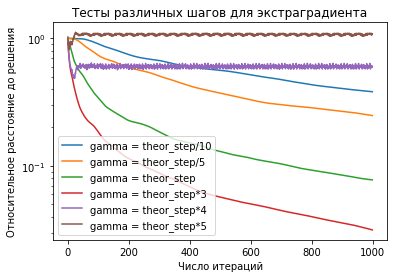

In [12]:
for i in range(len(steps)):
    plt.plot(range(len(gradients[i])),gradients[i],label="gamma = {}".format(steps_string[i]))
plt.yscale("log")
plt.xlabel("Число итераций")
plt.ylabel("Относительное расстояние до решения")
plt.title("Тесты различных шагов для экстраградиента")
plt.legend()

### Градиентный спуск

In [13]:
def GradientDescent(grad_f,z_start,step,iterations,proj,true_solution):
    z=z_start
    numbers=[]
    R0=np.linalg.norm(z_start-true_solution,2)
    for i in range(iterations):
        z=proj(z+step*grad_f(z))
        numbers.append(np.linalg.norm(z-true_solution,2)/R0) #Относительное расстояние 
    return z,numbers

Тестовые прогоны дали понять что на $\gamma=\frac{1}{10L}$ алгоритм сходится. Будем смотреть вокруг него. Проверим заодно теоретическую $mu/L^2$

In [14]:
start_step=1/L/10
steps=[start_step/20,start_step/10,start_step/5,start_step,start_step*5,mu/L/L]
gd_gradients=[]
for i in range(len(steps)):
    gd_gradients.append(GradientDescent(F,np.zeros(2*DIMENSIONS),steps[i],1000,segment_proj,np.hstack([bx,by]))[1])

In [15]:
gd_steps_string=["start_step/10","start_step/5","start_step","start_step*5","start_step*10","theor"]

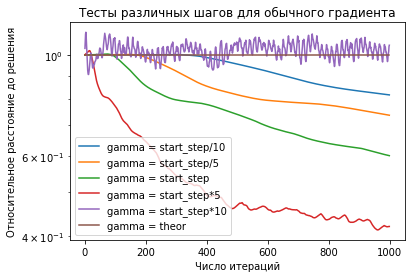

In [16]:
for i in range(len(steps)):
    plt.plot(range(len(gd_gradients[i])),gd_gradients[i],label="gamma = {}".format(gd_steps_string[i]))
plt.yscale("log")
plt.xlabel("Число итераций")
plt.ylabel("Относительное расстояние до решения")
plt.title("Тесты различных шагов для обычного градиента")
plt.legend()

Теоретическая вообще не сошлась

### Сравнительный график

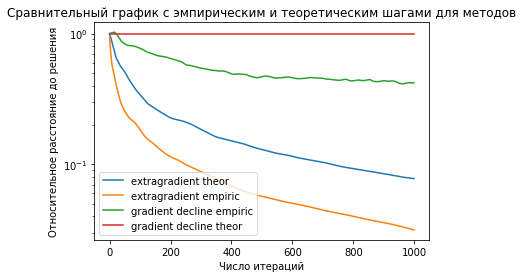

In [41]:
plt.plot(range(len(gradients[2])),gradients[2],label="extragradient theor")
plt.plot(range(len(gradients[3])),gradients[3],label="extragradient empiric")
plt.plot(range(len(gd_gradients[3])),gd_gradients[3],label="gradient decline empiric")
plt.plot(range(len(gd_gradients[-1])),gd_gradients[-1],label="gradient decline theor")
plt.legend()
plt.xlabel("Число итераций")
plt.ylabel("Относительное расстояние до решения")
plt.title("Сравнительный график с эмпирическим и теоретическим шагами для методов")
plt.yscale("log")

Экстраградиент бьет градиентный спуск, как и предполагалось

## Задача 2

Теперь рассмотрим билинейную задачу на симплексе. Описание задачи возьмите из [лекций](https://www2.isye.gatech.edu/~nemirovs/BrazilTransparenciesJuly4.pdf) - Слайд 125 "How it Works: Policeman vs. Burglar" и следующий.

__(а)__ Сгенерируйте матрицу для данной задачи размера $n=10$ c $\theta = 1$.

In [54]:
n=10
theta=1

Координаты дома определяются (k,l) где k и l меняются от нуля до девяти. k - ряд, в котором стоит дом, l - его номер в ряде  
Эти коориднаты переводятся в номер следующим образом : k*n+l    
В таком случае по номеру дома можно восстановить его координаты при помощи деления с остатком  

In [55]:
def get_coord(number):
    l=number%n
    k=(number-l)/n
    return np.array([k,l])

Богатство дома будет пропорционально расстоянию до дома (n/2,n/2). 
$w(i,j)=w_c-w_c*dist((i,j),(n/2,n/2))$

In [56]:
wc=10
def wealth(i):
    house_position=get_coord(i)
    central_house=np.array([n/2,n/2])
    return wc*(1-np.linalg.norm(house_position-central_house,2))

Теперь можно собрать матрицу

In [57]:
A=np.zeros([100,100])
for i in range(100):
    for j in range(100):
        dist_vector=get_coord(i)-get_coord(j)
        A[i][j]=wealth(i)*(1-np.exp(-theta*np.linalg.norm(dist_vector,2)))

__(б)__ Для данной задачи предложите модификацию метода Экстраградиента, которая учитывает, что задача решается на симплексе. В этом может помочь [статья](https://arxiv.org/pdf/0809.0815.pdf) (смотри Секцию 3.3). Реализуйте данный метод.

__(в)__ Решите билинейную задачу на симплексе с помощью нового метода и методов из Задачи 1. Как будете измерять сходимость? Возможно, в работах, из которых были взяты методы, найдется ответ. Постройте график сходимости. Визуализирйте полученный ответ, как это сделано в файле с лекциями. Сделайте вывод.  

### __Измерять сходимость__

Из статьи можно найти

$Err_{VI}(z):=\max_{u\in Z}\left<F(u),z-u \right>$

Подставив функцию и раскрыв скалярное произведение можно получить, что

$Err_{VI}(z)=\max_i(A y)-\min_i(A x)$

In [86]:
#Честная проекция на симплекс
def simplex_proj(z):
    x=z[:DIMENSIONS]
    y=z[DIMENSIONS:]
    x=true_simplex_proj(x)
    y=true_simplex_proj(y)
    return np.hstack([x,y])

#Проекция, предложенная в работе
def special_simplex_proj(z,xi):
    return np.exp(-xi)*z/(np.dot(z.T,np.exp(-xi)))


In [59]:
def simplex_Extragradient(F,gap,z_start,step,iterations,proj=default_proj):
    
    z=z_start
    gradients=[]
    gaps=[]
    for i in range(iterations):
        z_between=proj(z-step*F(z))
        z_new=proj(z-step*F(z_between))
        gaps.append(gap(z_new))
        z=z_new
    return z,gaps

In [60]:
def special_simplex_ExtraGradient(F,gap,z_start,step,iterations,proj=special_simplex_proj):
    
    z=z_start
    gradients=[]
    gaps=[]
    for i in range(iterations):
        z_between=proj(z,z-step*F(z))
        z_new=proj(z,z-step*F(z_between))
        gaps.append(gap(z_new))
        z=z_new
    return z,gaps

In [61]:
L=np.linalg.norm(A,2)
L

3067.6395551814735

In [62]:
def x_grad(A,x,y): 
    return np.dot(A,y)
def y_grad(A,x,y):
    return np.dot(A,x)

In [63]:
def F_prep(x_grad,y_grad,z):
    x=z[:DIMENSIONS]
    y=z[DIMENSIONS:]
    first=x_grad(A,x,y)
    second=-y_grad(A,x,y)
    return np.hstack([first,second])

In [64]:
F=lambda z:F_prep(x_grad,y_grad,z) 

In [65]:
def Err_prep(A,z):
    x=z[:DIMENSIONS]
    y=z[DIMENSIONS:]
    
    return np.max(np.dot(A,y)-np.min(np.dot(A,x)))

In [66]:
Err=lambda z : Err_prep(A,z)

# Тесты

## Экстраградиент с честной проекцией на симплекс

In [67]:
simp_res=simplex_Extragradient(F,Err,np.ones(2*DIMENSIONS)/DIMENSIONS,1/50/L,5000,proj=simplex_proj)

Text(0.5,1,'Сходимость экстраградиента с честной проекцией')

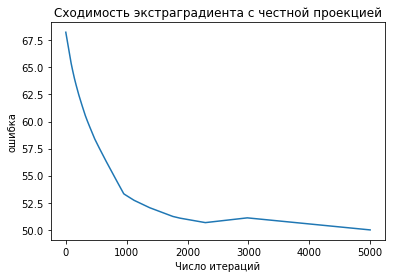

In [94]:
plt.plot(range(len(simp_res[1])),simp_res[1])
plt.xlabel("Число итераций")
plt.ylabel("ошибка")
plt.title("Сходимость экстраградиента с честной проекцией")
#plt.yscale("log")

Продолжает медленно монотонно спускаться

Переведем это обратно в формат матрицы

In [69]:
def want_matrix(answer):
    x=answer[:DIMENSIONS]
    y=answer[DIMENSIONS:]    
    policeman=np.zeros([10,10])
    burgler=np.zeros([10,10])
    for i in range(10):
        for j in range(10):
            burgler[i][j]=x[i*10+j]
            policeman[i][j]=y[i*10+j]
    return burgler,policeman

In [70]:
burgler,policeman=want_matrix(simp_res[0])

In [71]:
burgler

array([[0.37557326, 0.1560521 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.15616127],
       [0.1560521 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [72]:
policeman

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.20943132e-04, 1.34772733e-01, 2.37284664e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

Полицейский сидит в центре города, как и на картинке, но вор остался приемущественно в первом доме

# Градиентный спуск

In [73]:
def GradientDescent(grad_f,err,z_start,step,iterations,proj):
    z=z_start
    numbers=[]
    for i in range(iterations):
        z=proj(z+step*grad_f(z))
        numbers.append(err(z))
    return z,numbers

In [74]:
gd_res=GradientDescent(F,Err,np.ones(2*DIMENSIONS)/DIMENSIONS,1/L/100,2000,simplex_proj)

Text(0.5,1,'Сходимость градиентного спуска с честной проекцией')

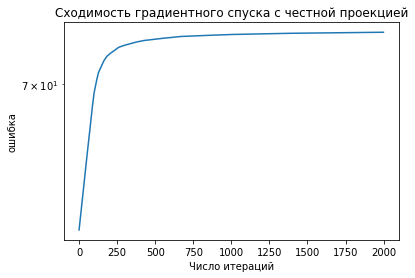

In [93]:
plt.plot(range(len(gd_res[1])),gd_res[1])
plt.yscale("log")
plt.xlabel("Число итераций")
plt.ylabel("ошибка")
plt.title("Сходимость градиентного спуска с честной проекцией")

Градиентный спуск не сходится(видимо проблемы с выпуклостью функции)

In [76]:
def want_matrix(answer):
    x=answer[:DIMENSIONS]
    y=answer[DIMENSIONS:]    
    policeman=np.zeros([10,10])
    burgler=np.zeros([10,10])
    for i in range(10):
        for j in range(10):
            burgler[i][j]=x[i*10+j]
            policeman[i][j]=y[i*10+j]
    return burgler,policeman

In [77]:
burgler,policeman=want_matrix(gd_res[0])


In [78]:
burgler

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.01296881,
        0.02790701, 0.01276697, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01296881, 0.06553304,
        0.09224827, 0.06547517, 0.01250044, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.02790701, 0.09224827,
        0.15701905, 0.09224827, 0.02756531, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01276697, 0.06547517,
        0.09224827, 0.06542208, 0.01233267, 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [79]:
policeman

array([[0.13577712, 0.09163726, 0.05364396, 0.02387674, 0.00467799,
        0.        , 0.00469154, 0.02390706, 0.05370109, 0.09174518],
       [0.09163726, 0.04197296, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04212181],
       [0.05364396, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.02387674, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00467799, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00469154, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.02390706, 0.        , 0.       

Здесь ситуация обратная к статье - вор сел в центре, а полицейский обитает на окраине

# Модификацированный алгоритм для работы с симплексом

In [87]:
new_simp_res=special_simplex_ExtraGradient(F,Err,np.ones(2*DIMENSIONS)/DIMENSIONS,1/L/100,2000,proj=special_simplex_proj)

Text(0.5,1,'Сходимость алгоритма с новой проекцией')

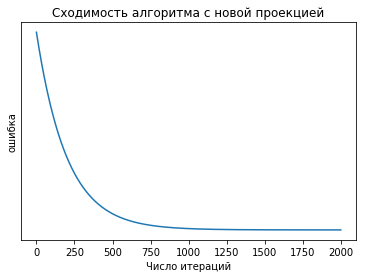

In [95]:
plt.plot(range(len(new_simp_res[1])),new_simp_res[1])
plt.yscale("log")
plt.xlabel("Число итераций")
plt.ylabel("ошибка")
plt.title("Сходимость алгоритма с новой проекцией")

Дошел до предела и больше не уменьшается

In [89]:
burgler,policeman=want_matrix(new_simp_res[0])

In [90]:
burgler

array([[0.00490354, 0.00491489, 0.00492422, 0.00493135, 0.00493588,
        0.00493744, 0.00493585, 0.00493124, 0.00492394, 0.00491419],
       [0.00491489, 0.00492749, 0.00493807, 0.00494639, 0.00495185,
        0.00495376, 0.00495182, 0.00494629, 0.00493777, 0.0049267 ],
       [0.00492422, 0.00493807, 0.00495013, 0.00496009, 0.00496697,
        0.00496948, 0.00496695, 0.00496   , 0.00494986, 0.00493731],
       [0.00493135, 0.00494639, 0.00496009, 0.00497218, 0.00498133,
        0.00498497, 0.00498132, 0.00497211, 0.00495986, 0.00494572],
       [0.00493588, 0.00495185, 0.00496697, 0.00498133, 0.00499401,
        0.00500039, 0.004994  , 0.00498129, 0.00496678, 0.00495124],
       [0.00493744, 0.00495376, 0.00496948, 0.00498497, 0.00500039,
        0.0050158 , 0.00500039, 0.00498493, 0.0049693 , 0.00495317],
       [0.00493585, 0.00495182, 0.00496695, 0.00498132, 0.004994  ,
        0.00500039, 0.004994  , 0.00498127, 0.00496676, 0.00495121],
       [0.00493124, 0.00494629, 0.00496  

In [91]:
policeman

array([[0.00509558, 0.00508442, 0.00507525, 0.00506824, 0.00506378,
        0.00506225, 0.00506381, 0.00506834, 0.00507552, 0.0050851 ],
       [0.00508442, 0.00507204, 0.00506164, 0.00505345, 0.00504808,
        0.0050462 , 0.00504811, 0.00505355, 0.00506193, 0.00507281],
       [0.00507525, 0.00506164, 0.00504977, 0.00503998, 0.00503322,
        0.00503075, 0.00503324, 0.00504007, 0.00505004, 0.00506237],
       [0.00506824, 0.00505345, 0.00503998, 0.0050281 , 0.00501911,
        0.00501553, 0.00501912, 0.00502817, 0.0050402 , 0.00505411],
       [0.00506378, 0.00504808, 0.00503322, 0.00501911, 0.00500666,
        0.00500039, 0.00500666, 0.00501915, 0.00503341, 0.00504868],
       [0.00506225, 0.0050462 , 0.00503075, 0.00501553, 0.00500039,
        0.00498527, 0.00500039, 0.00501557, 0.00503093, 0.00504678],
       [0.00506381, 0.00504811, 0.00503324, 0.00501912, 0.00500666,
        0.00500039, 0.00500667, 0.00501917, 0.00503343, 0.00504871],
       [0.00506834, 0.00505355, 0.0050400

Здесь они расселись равномерно

__Возможно сходимость можно починить если как-то иначе задавать богатство в домах__